In [107]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import pyodbc as db
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

start_year = 2007
end_year = 2017

years = [i for i in range(start_year, end_year + 1)]

# key columns
indices = ["unitid", "date_key"]

# value columns
cols = ["applcn", "applcnm", "applcnw", "admssn", "admssnm", "admssnw",
        "enrlt", "enrlm", "enrlw"]

types = {"UNITID" : np.int64,
         "APPLCN" : np.int32, "APPLCNM" : np.int32, "APPLCNW" : np.int32,
         "ADMSSN" : np.int32, "ADMSSNM" : np.int32, "ADMSSNW" : np.int32,
         "ENRLT" : np.int32, "ENRLM" : np.int32, "ENRLW" : np.int32,
         "ENRLFT" : np.int32, "ENRLFTM" : np.int32, "ENRLFTW" : np.int32,
         "ENRLPT" : np.int32, "ENRLPTM" : np.int32, "ENRLPTW" : np.int32}
# moto.test_column = pd.to_numeric(data.test_column, errors='coerce')
def fix_cols(dat):
    dat.columns = [colname.lower() for colname in list(dat.columns.values)]
    for col in cols:
        dat[col] = pd.to_numeric(dat[col], errors = "coerce")
years

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [130]:
df = DataFrame()

for year in years:
    # prior to 2014, admissions was reported in the IPEDS-IC survey rather than IPEDS-ADM
    if year < 2014:
        url = "https://nces.ed.gov/ipeds/datacenter/data/ic" + str(year) + ".zip"
        file_name = "ic" + str(year) + ".csv"
    else:
        url = "https://nces.ed.gov/ipeds/datacenter/data/adm" + str(year) + ".zip"
        file_name = "adm" + str(year) + ".csv"
        
    resp = urlopen(url)
    zipfile = ZipFile(BytesIO(resp.read()))
    myfile = zipfile.open(file_name)
    temp = pd.read_csv(myfile,
                       low_memory = False,
                       encoding = "iso-8859-1")
    fix_cols(temp)
    temp["date_key"] = (year * 10000) + 1015
    df = pd.concat([df, temp],
                   sort = True)
    temp = None
    
# df.columns = [colname.lower() for colname in list(df.columns.values)]

# select only needed columns
df = pd.concat((df[indices], df[cols]), axis = 1)

# replace NaN with zero
df = df.fillna(0)

df.shape

(26310, 11)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26310 entries, 1 to 2074
Data columns (total 11 columns):
unitid      26310 non-null int64
date_key    26310 non-null int64
applcn      26310 non-null float64
applcnm     26310 non-null float64
applcnw     26310 non-null float64
admssn      26310 non-null float64
admssnm     26310 non-null float64
admssnw     26310 non-null float64
enrlt       26310 non-null float64
enrlm       26310 non-null float64
enrlw       26310 non-null float64
dtypes: float64(9), int64(2)
memory usage: 2.4 MB


In [132]:
df.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1],:]

,unitid,date_key,applcn,applcnm,applcnw,admssn,admssnm,admssnw,enrlt,enrlm,enrlw
1,100654,20071015,6470.0,2507.0,3963.0,2059.0,799.0,1260.0,885.0,408.0,477.0
2,100663,20071015,4221.0,1674.0,2547.0,3705.0,1489.0,2216.0,1531.0,612.0,919.0
4,100706,20071015,1850.0,921.0,929.0,1628.0,845.0,783.0,800.0,424.0,376.0
5,100724,20071015,12436.0,7353.0,5083.0,5172.0,3214.0,1958.0,1366.0,589.0,777.0
7,100751,20071015,14313.0,6185.0,8128.0,9140.0,3908.0,5232.0,4538.0,2042.0,2496.0
2070,491057,20171015,15.0,15.0,0.0,14.0,14.0,0.0,12.0,12.0,0.0
2071,491163,20171015,15.0,4.0,11.0,12.0,3.0,9.0,12.0,3.0,9.0
2072,491288,20171015,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2073,491297,20171015,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2074,491303,20171015,5.0,2.0,3.0,4.0,1.0,3.0,4.0,1.0,3.0


In [133]:
# zero apps, non-zero admits
df.loc[(df["applcn"] == 0) & (df["admssn"] > 0), :]

,unitid,date_key,applcn,applcnm,applcnw,admssn,admssnm,admssnw,enrlt,enrlm,enrlw


In [134]:
# zero admits, non-zero enrollment
df.loc[(df["admssn"] == 0) & (df["enrlt"] > 0), :]

,unitid,date_key,applcn,applcnm,applcnw,admssn,admssnm,admssnw,enrlt,enrlm,enrlw


In [135]:
# total applications less than sum of parts
df.loc[df["applcn"] < df["applcnm"] + df["applcnw"],:]

,unitid,date_key,applcn,applcnm,applcnw,admssn,admssnm,admssnw,enrlt,enrlm,enrlw


In [136]:
# calculate unknowns
df["applcnu"] = df["applcn"] - (df["applcnm"] + df["applcnw"])
df["admssnu"] = df["admssn"] - (df["admssnm"] + df["admssnw"])
df["enrlu"] = df["enrlt"] - (df["enrlm"] + df["enrlw"])

df.loc[df["applcnu"] > 0, ["applcn", "applcnm", "applcnw", "applcnu"]].head()

,applcn,applcnm,applcnw,applcnu
35,883.0,0.0,0.0,883.0
42,2330.0,0.0,0.0,2330.0
85,25449.0,12163.0,13185.0,101.0
111,471.0,358.0,104.0,9.0
132,287.0,0.0,0.0,287.0


In [137]:
# reshape from wide to long format
adm_long = pd.melt(df, id_vars = ["unitid", "date_key"],
                   value_vars = ["applcnm", "applcnw", "applcnu",
                                 "admssnm", "admssnw", "admssnu",
                                 "enrlm", "enrlw", "enrlu"],
                   value_name = "count")

# field indicator
adm_long["field"] = np.where(adm_long["variable"].str.slice(0, 3) == "app", "applications", "unknown")
adm_long["field"] = np.where(adm_long["variable"].str.slice(0, 3) == "adm", "admissions", adm_long["field"])
adm_long["field"] = np.where(adm_long["variable"].str.slice(0, 3) == "enr", "enrollment", adm_long["field"])

# sex indicator
adm_long["sex"] = np.where(adm_long["variable"].str.slice(-1) == "w", "women", "unknown")
adm_long["sex"] = np.where(adm_long["variable"].str.slice(-1) == "m", "men", adm_long["sex"])

adm_long.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1],:]

,unitid,date_key,variable,count,field,sex
0,100654,20071015,applcnm,2507.0,applications,men
1,100663,20071015,applcnm,1674.0,applications,men
2,100706,20071015,applcnm,921.0,applications,men
3,100724,20071015,applcnm,7353.0,applications,men
4,100751,20071015,applcnm,6185.0,applications,men
236785,491057,20171015,enrlu,0.0,enrollment,unknown
236786,491163,20171015,enrlu,0.0,enrollment,unknown
236787,491288,20171015,enrlu,0.0,enrollment,unknown
236788,491297,20171015,enrlu,0.0,enrollment,unknown
236789,491303,20171015,enrlu,0.0,enrollment,unknown


In [138]:
adm_long["field"].value_counts()

enrollment      78930
applications    78930
admissions      78930
Name: field, dtype: int64

In [139]:
adm_long["demographic_key"] = "unknu"
adm_long["demographic_key"] = np.where(adm_long["sex"] == "men", "unknm", adm_long["demographic_key"])
adm_long["demographic_key"] = np.where(adm_long["sex"] == "women", "unknw", adm_long["demographic_key"])

adm_long["demographic_key"].value_counts()

unknu    78930
unknw    78930
unknm    78930
Name: demographic_key, dtype: int64

In [141]:
adm = adm_long.pivot_table(index=["unitid", "date_key", "demographic_key", "sex"],
                           columns='field',
                           values='count',
                           aggfunc = np.sum,
                           fill_value = 0).reset_index()

# remove institutions with no applications
adm = adm.loc[adm["applications"] > 0]

adm.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1],:]

field,unitid,date_key,demographic_key,sex,admissions,applications,enrollment
0,100654,20071015,unknm,men,799,2507,408
2,100654,20071015,unknw,women,1260,3963,477
3,100654,20081015,unknm,men,837,1664,476
5,100654,20081015,unknw,women,1104,2297,570
6,100654,20091015,unknm,men,1059,2273,507
78920,491163,20171015,unknw,women,9,11,9
78921,491288,20171015,unknm,men,0,2,0
78926,491297,20171015,unknw,women,1,1,0
78927,491303,20171015,unknm,men,1,2,1
78929,491303,20171015,unknw,women,3,3,3


In [150]:
adm["acceptance_rate"] = adm["admissions"] / adm["applications"]
adm["yield_rate"] = adm["enrollment"] / adm["admissions"]
adm["isUNL"] = np.where(adm["unitid"] == 181464, "UNL", "Others")

#  & (adm["acceptance_rate"] > 0) & (adm["acceptance_rate"] <= 1.0) & (adm["yield_rate"] > 0) & (adm["yield_rate"] <= 1.0)

cases = (adm["date_key"] == 20171015) & (adm["acceptance_rate"] < 1.0) & (adm["yield_rate"] < 1.0)
viz_set = adm[cases]

viz_set.shape

(3644, 10)

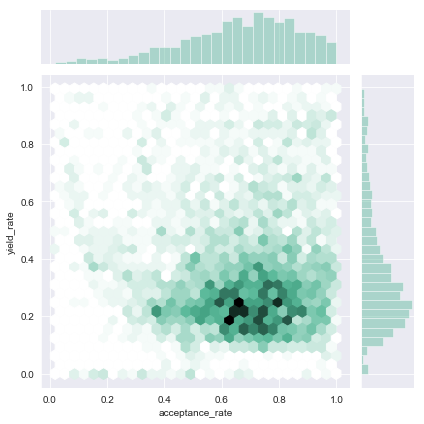

In [151]:
# Set theme
sns.set_style('darkgrid')

sns.jointplot(x = "acceptance_rate",
              y = "yield_rate",
              data = viz_set,
              kind="hex",
              color="#4CB391")